## Kaggle Diabetic Retinopathy Classification

### Train labels

 Loading the dataset

In [8]:
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import progressbar
import os

In [9]:
DS_BASE_PATH = './Data'

IMG_PATH = os.path.sep.join([DS_BASE_PATH, 'resized_train'])
csv_path = os.path.sep.join([DS_BASE_PATH,'trainLabels.csv'])

dataset = pd.read_csv(csv_path)
dataset

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
...,...,...
35121,44347_right,0
35122,44348_left,0
35123,44348_right,0
35124,44349_left,0


level
0    25810
1     2443
2     5292
3      873
4      708
Name: image, dtype: int64

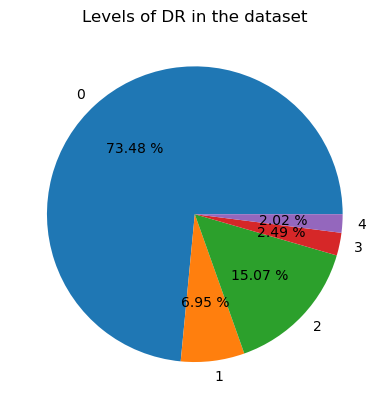

In [10]:
display(dataset.groupby('level')['image'].count())
classes = 5
plt.pie([dataset.loc[dataset['level'] == n].count()[0] for n in range(classes)], labels = range(classes), autopct='%.2f %%')
plt.title("Levels of DR in the dataset")
plt.show()

level
0    700
1    700
2    700
3    700
4    700
Name: image, dtype: int64

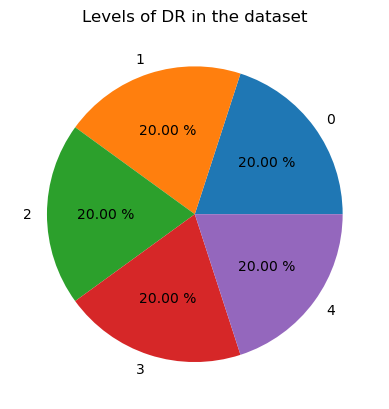

In [11]:
dataset = dataset.groupby(['level']).sample(700)
display(dataset.groupby('level')['image'].count())

plt.pie([dataset.loc[dataset['level'] == n].count()[0] for n in range(classes)], labels = range(classes), autopct='%.2f %%')
plt.title("Levels of DR in the dataset")
plt.show()

In [12]:
x_train, x_remain, y_train, y_remain = train_test_split(
    dataset['image'],
    dataset['level'],
    train_size=0.7,
    test_size=0.3,
    random_state=42
)

In [13]:
train_df = pd.DataFrame()
train_df['image'] = x_train
train_df['level'] = y_train

In [14]:
remain_df = pd.DataFrame()
remain_df['image'] = x_remain
remain_df['level'] = y_remain

In [15]:
x_val, x_test, y_val, y_test = train_test_split(
    dataset['image'],
    dataset['level'],
    train_size=0.5,
    test_size=0.5,
    random_state=42
)

In [16]:
val_df = pd.DataFrame()
val_df['image'] = x_val
val_df['level'] = y_val

In [17]:
test_df = pd.DataFrame()
test_df['image'] = x_test
test_df['level'] = y_test

level
0    462
1    495
2    494
3    512
4    487
Name: image, dtype: int64

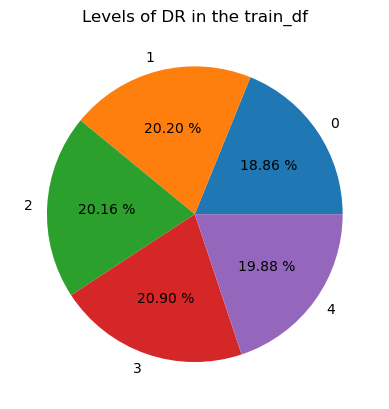

,image,level
27318,34571_left,3
33511,42337_right,0
7826,9821_left,1
12963,16294_right,2
4140,5185_left,2


In [18]:
display(train_df.groupby(['level'])['image'].count())
plt.pie([train_df.loc[train_df['level'] == n].count()[0] for n in range(classes)], labels = range(classes), autopct='%.2f %%')
plt.title("Levels of DR in the train_df")
plt.show()
train_df.head()

level
0    337
1    352
2    344
3    357
4    360
Name: image, dtype: int64

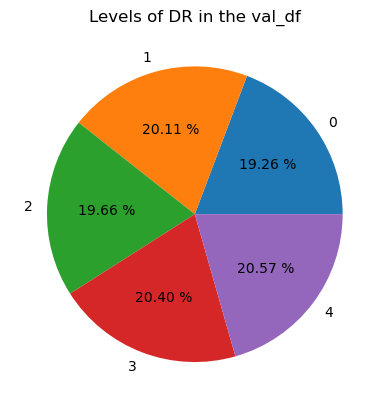

,image,level
1997,2496_right,3
14032,17629_left,1
31803,40178_right,4
2562,3194_left,2
20141,25407_right,4


In [19]:
display(val_df.groupby(['level'])['image'].count())
plt.pie([val_df.loc[val_df['level'] == n].count()[0] for n in range(classes)], labels = range(classes), autopct='%.2f %%')
plt.title("Levels of DR in the val_df")
plt.show()
val_df.head()

level
0    363
1    348
2    356
3    343
4    340
Name: image, dtype: int64

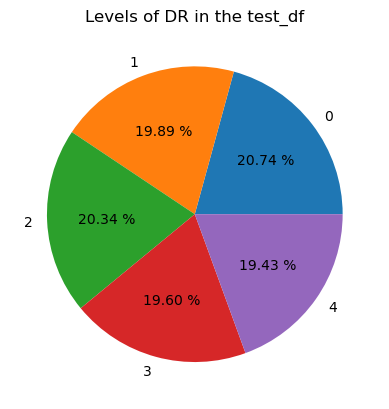

,image,level
24042,30367_left,2
11057,13889_right,3
7844,9846_left,3
31379,39646_right,2
16402,20546_left,0


In [20]:
display(test_df.groupby(['level'])['image'].count())
plt.pie([test_df.loc[test_df['level'] == n].count()[0] for n in range(classes)], labels = range(classes), autopct='%.2f %%')
plt.title("Levels of DR in the test_df")
plt.show()
test_df.head()

In [21]:
def reset_path(directory:str):
    """
    Deletes an existing directory and re-creates it

    - directory: path to directory
    """
    if os.path.exists(directory):
        !rm -r {directory}
    os.mkdir(directory)

def create_path(base_dir:str, dir_name:str):
    directory = os.path.sep.join([base_dir, dir_name])
    """
    Creates a new directory if it doesn't exist already

    - dir_name: path to directory
    """
    if not os.path.exists(directory):
        os.mkdir(directory)
    else:
        print(f'[INFO] {directory} already exists')
    
    return directory

def organize_set_imgs(df: pd.DataFrame, set_path:str):

    # images divided by class dir
    class_directories = {str(k):list(df['image'].loc[df['level'] == k]) for k in range(classes)}
    # display(class_directories)

    for k,imgs in class_directories.items():
        class_dir = create_path(set_path, k)

        widgets = [
            f'Building {set_path.split(os.path.sep)[-1]}/{k}:',
            ' ',
            progressbar.Percentage(),
            ' ',
            progressbar.Bar(),
            ' ',
            progressbar.Counter()
        ]

        pbar = progressbar.ProgressBar(widgets=widgets, maxval=len(imgs))
        
        pbar.start()

        for i, img in enumerate(imgs):
            im_origin = os.path.sep.join([IMG_PATH, f'{img}.jpeg'])

            !cp {im_origin} {class_dir}

            pbar.update(i)
        
    pbar.finish()


In [22]:
DB_PATH = './DB'

reset_path(DB_PATH)

train_path = create_path(DB_PATH, 'Train')
organize_set_imgs(train_df, train_path)

val_path = create_path(DB_PATH, 'Val')
organize_set_imgs(val_df, val_path)

test_path = create_path(DB_PATH, 'Test')
organize_set_imgs(test_df, test_path)

Building Train/4: 100% |##################################################| 487
Building Val/4: 100% |####################################################| 360
Building Test/4: 100% |###################################################| 340
